# Planet to planet low-thrust (with Alpha encoding)

In this tutorial we show the use of the {class}`pykep.trajopt.direct_pl2pl_alpha` to find a low-thrust (multiple impulses) trajectory connecting two moving planets. 
Unlike in `pykep.trajopt.direct_pl2pl`, where the impulses are equally spaced, here we use the alpha encoding to move the spacing of the impulses. The impulse is placed at the centre of a time-interval. 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, \alpha_{0}, \alpha_{1}, ..., u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0$ as a MJD2000, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

The time-intervals (direct) are encoded using the alpha encoding and represented in the optimisation vector as $\alpha_{0}, \alpha_{1}, ...,$. These can be converted to and from direct times using `alpha2direct` and `direct2alpha`.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. (Currently no gradients have been implemented for the alpha encoding, so it can't use IPOPT or SLSQP)

Basic imports:

In [1]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data. For the purpose of this simple notebook we choose a simple Earth to Mars transfer.

In [2]:
# # Problem data

####
## Testcase Earth-Mars
mu = pk.MU_SUN
max_thrust = 0.6
isp = 3000
tof = 550.0
tof_lb = tof
t0_lb = 0
t0_ub = 0

posvel0 = [
    [-125036811000.422, -83670919168.87277, 2610252.8064399767],
    [16081.829029183446, -24868.923007449284, 0.7758272135425942]
]
posvelf = [
    [-169327023332.1986, -161931354587.78766, 763967345.9733696],
    [17656.297796509956, -15438.116653052988, -756.9165272457421]
]

# Define initial and target
p1 = pk.planet(pk.udpla.keplerian(when=pk.epoch(0), posvel = posvel0, mu_central_body=mu))
p2 = pk.planet(pk.udpla.keplerian(when=pk.epoch(tof), posvel = posvelf, mu_central_body=mu))

# Initial state
ms = 1500.0
opt_mass = 1237.68
opt_thresh = 0.999

# Number of segments
nseg = 4

We here instantiate two different versions of the same UDP (User Defined Problem), with alpha encoding and without. 

In [3]:
udp_lf = pk.trajopt.direct_pl2pl(
        pls=p1,
        plf=p2,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        isp=isp,
        t0_bounds=[t0_lb, t0_ub],
        tof_bounds=[tof_lb,tof],
        mf_bounds=[ms*0.25, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        with_gradient=False,
        high_fidelity=False
)

udp_alpha = pk.trajopt.direct_pl2pl_alpha(
        pls=p1,
        plf=p2,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        isp=isp,
        t0_bounds=[t0_lb, t0_ub],
        tof_bounds=[tof_lb,tof],
        mf_bounds=[ms*0.25, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=0.6,
        mass_scaling=ms,
        r_scaling=pk.AU,
        v_scaling=pk.EARTH_VELOCITY,
        high_fidelity=False
)

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

:::{note}
This tolerance has a different role from the numerical tolerance set in the particular algorithm chosen to solve the problem and is only used by the *pagmo* machinery to decide outside the optimizer whether the new proposed indivdual is better than what was the previous *champion*.

In [4]:

# Low Fidelity
prob_lf = pg.problem(udp_lf)
prob_lf.c_tol = 1e-6

# With Alpha
prob_alpha = pg.problem(udp_alpha)
prob_alpha.c_tol = 1e-6

... and we define an optimization algorithm.

SNOPT

In [ ]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

algo = pg.algorithm(uda)

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

Without alpha encoding

In [6]:
# Low fidelity
start_time = time.time()
steps = 10

masses_lf = []
xs_lf = []
for i in range(steps):
    pop_lf = pg.population(prob_lf, 1)
    pop_lf = algo.evolve(pop_lf)
    if(prob_lf.feasibility_f(pop_lf.champion_f)):
        print(".", end="")
        masses_lf.append(pop_lf.champion_x[1])
        xs_lf.append(pop_lf.champion_x)
        # break
    else:
        print("x", end ="")
print("\nLow-fidelity. Nseg: ", nseg)
print("Best mass: ", np.max(masses_lf))
comp_time = time.time() - start_time
print("Time: ", comp_time,'s',comp_time/steps,'per step')
best_idx_lf = np.argmax(masses_lf)

.xxxx.....
Low-fidelity. Nseg:  4
Best mass:  1233.2124383030502
Time:  2.1656720638275146 s 0.21656720638275145 per step


Now solve with Alpha encoding

In [7]:
# With Alpha
start_time = time.time()
steps = 10

masses_alpha = []
xs_alpha = []
for i in range(steps):
    pop_alpha = pg.population(prob_alpha, 1)
    
    # Push back average spacing
    x_tmp = pop_alpha.champion_x
    x_tmp[8:8+nseg] = pk.direct2alpha([1/nseg]*nseg)[0]
    pop_alpha.push_back(x_tmp)

    # if i == 0: # Push back the constant result
    # pop_alpha.push_back(x_tmp)
    
    pop_alpha = algo.evolve(pop_alpha)
    if(prob_alpha.feasibility_f(pop_alpha.champion_f)):
        print(".", end="")
        masses_alpha.append(pop_alpha.champion_x[1])
        xs_alpha.append(pop_alpha.champion_x)
        # break
    else:
        print("x", end ="")
print("\nLow-fidelity Alpha. Nseg: ", nseg)
print("Best mass: ", np.max(masses_alpha))
# print("Worst mass: ", np.min(masses_alpha))

comp_time = time.time() - start_time
print("Time: ", comp_time,'s',comp_time/steps,'per step')
best_idx_alpha = np.argmax(masses_alpha)

....x.x..x
Low-fidelity Alpha. Nseg:  4
Best mass:  1237.8158587565292
Time:  4.4765379428863525 s 0.4476537942886353 per step


Visualise the time intervals

In [8]:
alphas = xs_alpha[best_idx_alpha][8:8+nseg]
talphas = pk.alpha2direct(alphas, 1)
print('Alphas: ',alphas)
print('talphas: ',talphas)

Alphas:  [0.74012435 0.67994673 0.60653066 0.88249605]
talphas:  [0.22942892613886648, 0.29408175418469246, 0.38119086703959604, 0.09529845263684492]


And we plot the trajectory found:

In [9]:
# udp_lf.pretty(xs_lf[best_idx_lf])

# udp_hf.pretty(xs_hf[best_idx_hf])

# udp_alpha.pretty(xs_alpha[best_idx_alpha])

Text(0.5, 0.92, 'SF LF with Alpha Encoding, Mass: 1237.82 kg, Nseg: 4')

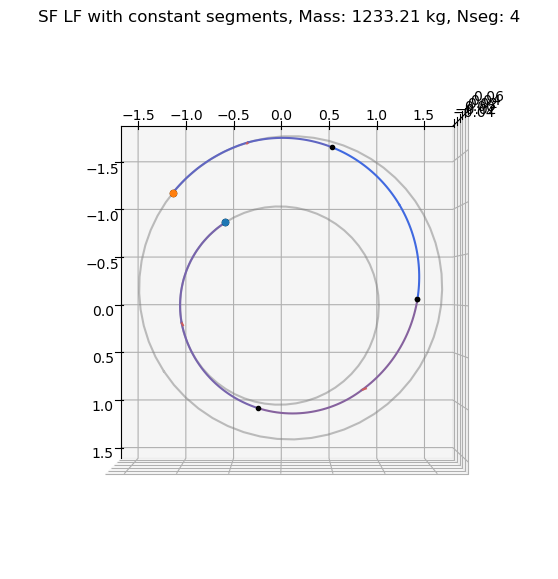

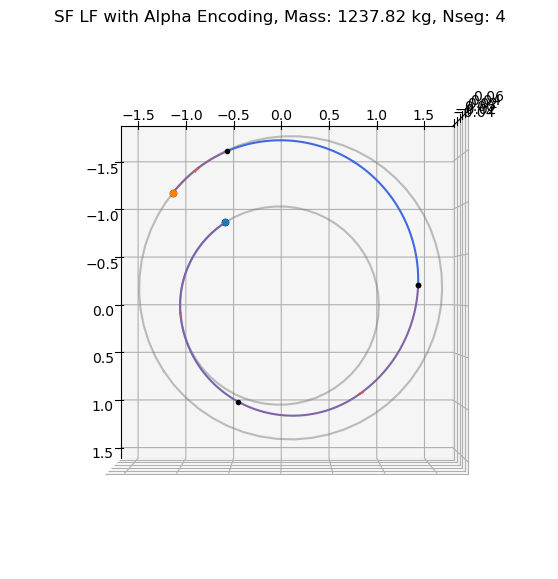

In [10]:
# Plot with low-fidelity
ax = udp_lf.plot(xs_lf[best_idx_lf], show_gridpoints=True, show_throttles=True)
ax.view_init(90, 0)
ax.set_title(f'SF LF with constant segments, Mass: {np.max(masses_lf):.2f} kg, Nseg: {nseg}')

# Plot With Alpha
ax = udp_alpha.plot(xs_alpha[best_idx_alpha], show_gridpoints=True, show_throttles=True)
ax.view_init(90, 0)
ax.set_title(f'SF LF with Alpha Encoding, Mass: {np.max(masses_alpha):.2f} kg, Nseg: {nseg}')